In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import random
import math
import itertools
import pandas as pd
from scipy.optimize import minimize
from numpy import linalg as LA

import warnings
warnings.filterwarnings("ignore")

def column(vector):
    return np.array(np.matrix(vector)).T

# Logistic Regression classifier for facial expressions

The folder *Faces* contains 974 images of people posing facial expressions and their respective landmarks ($n$ landmarks for each facial expression). Each landmark is a coordinate in two dimensions. The penultimate letter of the name of each file indicates what type of facial expression the person is posing. The notation is as follows: `n` for neutral, `h` for happy, `s` for sad, `a` for angry, `d` for disgust, and `f` for fear. We are only going to use the landmarks; the images are for referencing the landmarks.

We aim to train a classifier to classify a facial expression as "Happy" or "Not happy". We assume that the facial expression related to happiness is class 1, and any other facial expression is class 0.

### a) Split the data

From the total set of images, we extract only the images with their landmarks of happiness emotion. This would be the set of class 1, and let $N_h$ be the size of this set. Now, from the rest of the images of all other emotions, we extract a subset of size $N_h$ such that the number of samples of each emotion is as balanced as possible. That is, the number of images of neutral, sad, angry, disgusted, and fearful expressions should each be as close as possible to $N_{h}/5$. This subset is the set of class 0.


In [2]:
# Directory where the landmark data is stored is declared.
dataDir = "Faces/markings/"
data = []
# Each file is loaded and saved in the list called data.
for file in os.listdir(dataDir):
    data.append(scipy.io.loadmat(dataDir+file))


In [3]:
# class1 -> happy
# clase0 -> subset of size len(class1) taken from the set remaining after removing happy data from the total dataset

class1 = []
class1_indices = []

# In this list there will be 803 data points. From these 803 data points, we are going to take only 171 randomly,
# evenly distributed among facial expressions.
not_class1 = []
not_class1_indices = []

# We iterate through the files and classify each one according to its respective facial expression. Additionally, we save
# their respective indices within the list of files.
for file in os.listdir(dataDir):
    if file[8] == "n":
        not_class1.append(file)
        not_class1_indices.append(os.listdir(dataDir).index(file))
    elif file[8] == "h":   
        class1.append(file)
        class1_indices.append(os.listdir(dataDir).index(file))
    elif file[8] == "s":
        not_class1.append(file)
        not_class1_indices.append(os.listdir(dataDir).index(file))
    elif file[8] == "f":
        not_class1.append(file)
        not_class1_indices.append(os.listdir(dataDir).index(file))
    elif file[8] == "a":
        not_class1.append(file) 
        not_class1_indices.append(os.listdir(dataDir).index(file))
    elif file[8] == "d":
        not_class1.append(file)
        not_class1_indices.append(os.listdir(dataDir).index(file))


In [4]:
# We create a list of lists, to be able to iterate through them.
lists = [class1, not_class1]

# We print the length of each of the newly created lists.
for lst in lists:
    if lst == class1:
        print(f'Class 1 (happy): {len(lst)} elements')
    elif lst == not_class1:
        print(f'Not Class 1: {len(lst)} elements')

print(f'Total: {len(class1) + len(not_class1)} elements')


Class 1 (happy): 171 elements
Not Class 1: 803 elements
Total: 974 elements


In [5]:
# We create lists to store the strings of the files corresponding to each facial expression, along with their corresponding list to know the indices where those facial expressions are within the 'not_class1' list.

neutral = []
indices_neutral = []

sad = []
indices_sad = []

fear = []
indices_fear = []

angry = []
indices_angry = []

disgust = []
indices_disgust = []

# We find the indices where each facial expression is located within the 'not_class1' list.
for file in not_class1:
    if file[8] == "n":
        neutral.append(file)
        indices_neutral.append(not_class1.index(file))
    elif file[8] == "s":
        sad.append(file)
        indices_sad.append(not_class1.index(file))
    elif file[8] == "f":
        fear.append(file)
        indices_fear.append(not_class1.index(file))
    elif file[8] == "a":
        angry.append(file)
        indices_angry.append(not_class1.index(file))
    elif file[8] == "d":
        disgust.append(file)
        indices_disgust.append(not_class1.index(file))

# We create lists for each facial expression where the actual data (landmarks) of each facial expression will go.
data_neutral = []
data_sad = []
data_fear = []
data_angry = []
data_disgust = []

# We populate these lists to store the data of each facial expression.
for index in indices_neutral:
    data_neutral.append(data[index]['faceCoordinatesUnwarped'])

for index in indices_sad:
    data_sad.append(data[index]['faceCoordinatesUnwarped'])

for index in indices_fear:
    data_fear.append(data[index]['faceCoordinatesUnwarped'])

for index in indices_angry:
    data_angry.append(data[index]['faceCoordinatesUnwarped'])

for index in indices_disgust:
    data_disgust.append(data[index]['faceCoordinatesUnwarped'])

# We create a list to store the data of Class 1.
data_class1 = []

# We populate the list with the data of class 1.
for index in class1_indices:
    data_class1.append(data[index]['faceCoordinatesUnwarped'])

# We create a list to store the data of Class 0.
data_class0 = []

# We randomly choose data from each facial expression to fill Class 0. The chosen k ensures that data from each facial
# expression is chosen fairly.
neutral_in_class0 = random.sample(data_neutral, k=35)
sad_in_class0 = random.sample(data_sad, k=35)
fear_in_class0 = random.sample(data_fear, k=34)
angry_in_class0 = random.sample(data_angry, k=34)
disgust_in_class0 = random.sample(data_disgust, k=33)

# We add the data to the list.
data_class0.append(neutral_in_class0)
data_class0.append(sad_in_class0)
data_class0.append(fear_in_class0)
data_class0.append(angry_in_class0)
data_class0.append(disgust_in_class0)

# This line is to have a list with all the data, not a list of 5 lists.
data_class0 = list(itertools.chain.from_iterable(data_class0))

print(f'\nNumber of data in Class 1: {len(data_class1)}\n')
print(f'Number of data in Class 0: {len(data_class0)}\n')



Number of data in Class 1: 171

Number of data in Class 0: 171



### b) Create balanced training and validation lists for each class

In [6]:
# We determine the numbers of data that should be in each training and validation set.
num_training1 = math.ceil(0.8 * len(data_class1))
num_valid1 = math.floor(0.2 * len(data_class1))

print(f'Number of training data for class 1: {num_training1} \n')
print(f'Number of validation data for class 1: {num_valid1} \n')

num_training0 = math.ceil(0.8 * len(data_class0))
num_valid0 = math.floor(0.2 * len(data_class0))

print(f'Number of training data for class 0: {num_training0} \n')
print(f'Number of validation data for class 0: {num_valid0} \n')

# We are going to separate the data of each class into training (80%) and validation (20%) sets, i.e.,
# we are going to have 2 training lists and 2 validation lists, one for each class.

# We create the lists where we will store the training and validation data for each class.
training1 = []
validation1 = []

training0 = []
validation0 = []


Number of training data for class 1: 137 

Number of validation data for class 1: 34 

Number of training data for class 0: 137 

Number of validation data for class 0: 34 



Fill training list for each class

In [7]:
# We take k data from Class 1 randomly to add them to the training data of Class 1.
random_class1 = random.sample(data_class1, k=num_training1)
training1.append(random_class1)

# List to store the indices of the randomly obtained Class 1 data
in_class1 = []

# We get the indices of the randomly generated elements (within the data_class1 list).
for i, data_point in enumerate(data_class1):
    for j, random_data_point in enumerate(random_class1):
        if (data_point == random_data_point).all():
            in_class1.append(i)

# We create a new list that does not include the data whose indices were to be deleted.
class1_without_training = [data_point for i, data_point in enumerate(data_class1) if i not in in_class1]

##########################################################################################

# We do the same, but now with class 0.
random_class0 = random.sample(data_class0, k=num_training0)
training0.append(random_class0)

# List to store the indices of the randomly obtained Class 0 data
in_class0 = []

# We get the indices of the randomly generated elements (within the data_class0 list).
for i, data_point in enumerate(data_class0):
    for j, random_data_point in enumerate(random_class0):
        if (data_point == random_data_point).all():
            in_class0.append(i)

# We create a new list that does not include the data whose indices were to be deleted.
class0_without_training = [data_point for i, data_point in enumerate(data_class0) if i not in in_class0]

# These lines are to ensure we have a list with all the data, not a list of 2 lists.
training1 = list(itertools.chain.from_iterable(training1))
training0 = list(itertools.chain.from_iterable(training0))


We fill the validation list of each class

In [8]:
# We take data from Class 1 randomly to add them to the validation data.
random_class1_v = random.sample(class1_without_training, k=num_valid1)
validation1.append(random_class1_v)

##########################################################################################

# We take data from Class 0 randomly to add them to the validation data.
random_class0_v = random.sample(class0_without_training, k=num_valid0)
validation0.append(random_class0_v)

# These lines are to ensure we have a list with all the data, not a list of 2 lists.
validation1 = list(itertools.chain.from_iterable(validation1))
validation0 = list(itertools.chain.from_iterable(validation0))


### c) Procrustes Mean

With only the training data from both classes, calculate the Procrustes mean of the landmarks. This is a Procrustes mean for all the training data, not a mean for each class. Using this Procrustes mean, we align the landmarks in the training and validation partitions. This step would be the preprocessing (i.e., there is no need to standardize the data).


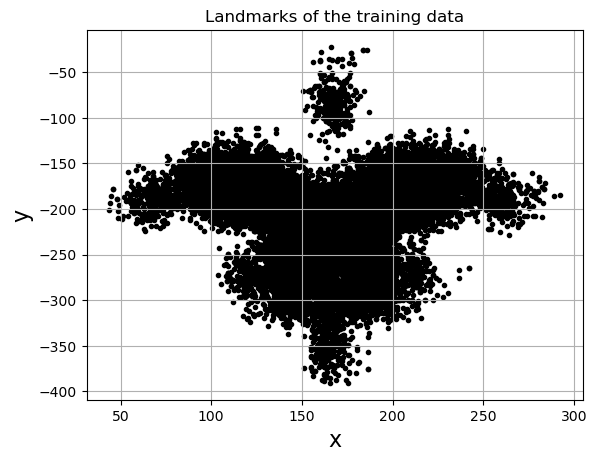

In [9]:
# We are going to use only the training data from both classes to calculate the Procrustes mean. That is, we are going
# to create a global list of training data.

training = [training1, training0]
training = list(itertools.chain.from_iterable(training))

# We plot the training data.
plt.figure()
plt.grid()
for data_point in training:
    plt.scatter(data_point[:, 0], -data_point[:, 1], color='black', marker='.')
plt.title('Landmarks of the training data')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()


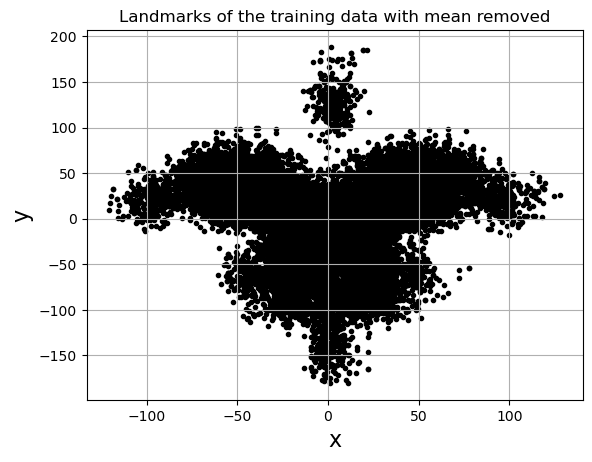

In [10]:
# We remove the mean from each shape.

# We concatenate all the training data so that they are all in a single matrix of 67*len(training) x 2.
train = np.vstack(training)

# Real part of the data (coordsX)
wr = train[:, 0]

# Imaginary part of the data (coordsY)
wi = train[:, 1]

# We obtain the mean of each coordinate, and then remove it.
mean_wr = np.mean(wr)
mean_wi = np.mean(wi)

wr_without_mean = wr - mean_wr
wi_without_mean = wi - mean_wi

# We plot the landmarks with the mean removed (from Class 1).
plt.figure()
plt.grid()
plt.scatter(wr_without_mean, -wi_without_mean, color='black', marker='.')
plt.title('Landmarks of the training data with mean removed')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()


In [11]:
# Now we are going to find the Procrustes mean for all the training data.

# Matrix S
S = np.zeros((len(training[0]), len(training[0])))
# We generate a vector that includes the information of coordsX and coordsY as a vector of complex components.
w_complex = np.zeros((len(training[0]), 1), dtype=complex)

# We construct the matrix S
first = True
for i in range(len(training)):
    data_point = training[i]
    for j in range(len(data_point)):
        w_complex[j] = complex(data_point[j][0], data_point[j][1])
    if first:
        S = w_complex @ np.transpose(np.conj(w_complex))
        first = False
    else:
        S = S + w_complex @ np.transpose(np.conj(w_complex))


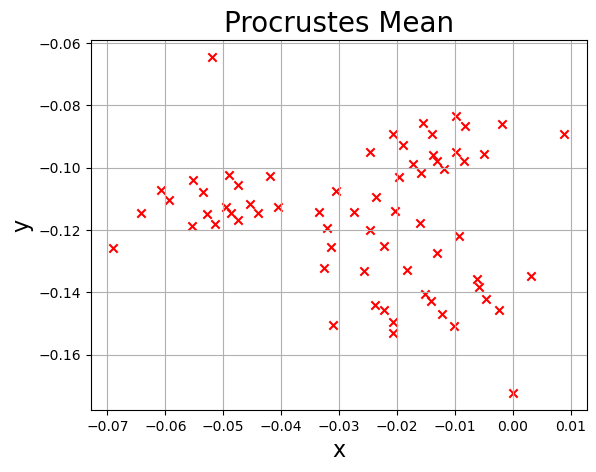

In [12]:
# We are going to find the Procrustes mean.

# w is an array with the eigenvalues
# v is a matrix whose columns are the eigenvectors
# the eigenvalue at w[i] is associated with the column v[:,i]
w, v = LA.eig(S)

# Find the index within the matrix v where the eigenvector associated with the largest eigenvalue is located.
maximum = np.abs(np.amax(w))
index = 0

for i in range(len(w)):
    if np.abs(w[i]) == maximum:
        index = i

# Procrustes mean
procrustes_mean = v[:, index]
coordsX = procrustes_mean.real
coordsY = procrustes_mean.imag

plt.figure()
plt.grid()
plt.scatter(coordsY, -coordsX, color='red', marker='x')
plt.title('Procrustes Mean', fontsize=20)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.show()


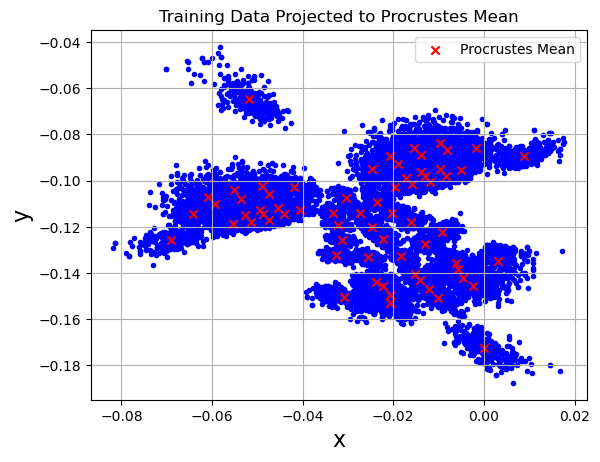

In [13]:
# Now we are going to align the landmarks in the training and validation partitions to the Procrustes mean

################ Training Data ####################

# We create a list to save the data adjusted to the Procrustes mean.
training_mean = []

# This is the vector we are going to adjust to the Procrustes mean.
w_tr_comp = np.zeros((len(training[0]), 1), dtype=complex)

# Fill the complex vector to be able to use it to adjust to the Procrustes mean.
for i in range(len(training)):
    data = training[i]
    for j in range(len(data)):
        w_tr_comp[j] = complex(data[j][0], data[j][1])

    # Adjustment is made and the adjusted data is added to the list of training data adjusted to the Procrustes mean.
    wp_tr = w_tr_comp*((np.transpose(np.conj(w_tr_comp))@procrustes_mean)/((np.transpose(np.conj(w_tr_comp))@w_tr_comp)))
    training_mean.append(wp_tr)

    # Separate the X coordinates and Y coordinates
    wp_tr_r = wp_tr.real
    wp_tr_i = wp_tr.imag

    # Plot the data
    plt.scatter(wp_tr_i, -wp_tr_r, color='blue', marker='.')

# Plot the Procrustes mean along with the adjusted data.
plt.grid()
plt.scatter(coordsY, -coordsX, color='red', marker='x', label='Procrustes Mean')
plt.title('Training Data Projected to Procrustes Mean')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()
plt.show()


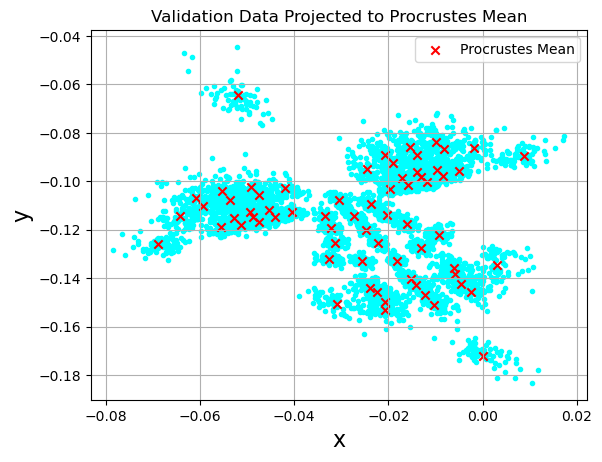

In [14]:
################# Validation Data ##################

# Create a global list of validation data
validation = [validation1, validation0]
validation = list(itertools.chain.from_iterable(validation))

# Create a list to save the data adjusted to the Procrustes mean.
validation_mean = []

# This is the vector we are going to adjust to the Procrustes mean.
w_val_comp = np.zeros((len(validation[0]), 1), dtype=complex)

# Fill the complex vector to be able to use it to adjust to the Procrustes mean.
for i in range(len(validation)):
    data = validation[i]
    for j in range(len(data)):
        w_val_comp[j] = complex(data[j][0], data[j][1])

    # Adjustment is made and the adjusted data is added to the list of validation data adjusted to the Procrustes mean.
    wp_val = w_val_comp*((np.transpose(np.conj(w_val_comp))@procrustes_mean)/((np.transpose(np.conj(w_val_comp))@w_val_comp)))
    validation_mean.append(wp_val)

    # Separate the X coordinates and Y coordinates
    wp_val_r = wp_val.real
    wp_val_i = wp_val.imag

    # Plot
    plt.scatter(wp_val_i, -wp_val_r, color='cyan', marker='.')

# Plot the Procrustes mean along with the adjusted data.
plt.grid()
plt.scatter(coordsY, -coordsX, color='red', marker='x', label='Procrustes Mean')
plt.title('Validation Data Projected to Procrustes Mean')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend()
plt.show()


### d) With the aligned landmarks, we create a feature vector of size 134 for each training and validation image.

The first feature corresponds to the horizontal component of landmark 1, and the second feature corresponds to the vertical component of landmark 1 of the facial expression. We repeat this procedure for the rest of the landmarks.


#### Training data

In [15]:
# Within the training data (training), the first 137 correspond to class 1 and the following 137 correspond to class 0.
cClass1_tr = 137
cClass0_tr = cClass1_tr + 137

numClass1_tr = cClass1_tr
numClass0_tr = cClass0_tr - cClass1_tr

# Create 2 matrices of size (2n = 134)x(numData_class): one for each class, of size numClass1_tr and numClass0_tr respectively.
mClass1_train = np.zeros((2*len(training_mean[0]), numClass1_tr))
mClass0_train = np.zeros((2*len(training_mean[0]), numClass0_tr))

# Iterate over the number of training data we have (in this case we have 137*2 = 274) and inquire in which data range we are with the help of the counters created above. Depending on the range, we know which class we are in. We fill the vector corresponding to each class with the coordsX (real part) and coordsY (imaginary part).
for i in range(len(training_mean)):
    data = training_mean[i]
    dataNew = np.zeros((2*len(data), 1))
    for j in range(len(data)):
        dataNew[j*2] = data.real[j]
        dataNew[j*2+1] = data.imag[j]
    if i < cClass1_tr:
        mClass1_train[:,i] = column(dataNew)
    elif i >= cClass1_tr and i < cClass0_tr:
        k = i - cClass1_tr
        mClass0_train[:,k] = column(dataNew)


#### Validation data

In [16]:
# Within the validation data (validation), the first 34 correspond to class 1 and the following 34 correspond to class 0.
cClass1_val = 34
cClass0_val = cClass1_val + 34

numClass1_val = cClass1_val
numClass0_val = cClass0_val - cClass1_val

# Create 2 matrices of size (2n = 134)x(numData_class): one for each class, of size numClass1_val and numClass0_val respectively.
mClass1_val = np.zeros((2*len(validation_mean[0]), numClass1_val))
mClass0_val = np.zeros((2*len(validation_mean[0]), numClass0_val))

# Iterate over the number of validation data we have (in this case we have 34*2 = 68) and inquire in which data range we are with the help of the counters created above. Depending on the range, we know which class we are in. We fill the vector corresponding to each class with the coordsX (real part) and coordsY (imaginary part).
for i in range(len(validation_mean)):
    data = validation_mean[i]
    dataNew = np.zeros((2*len(data), 1))
    for j in range(len(data)):
        dataNew[j*2] = data.real[j]
        dataNew[j*2+1] = data.imag[j]
    if i < cClass1_val:
        mClass1_val[:,i] = np.array(np.matrix(dataNew)).T
    elif i >= cClass1_val and i < cClass0_val:
        k = i - cClass1_val
        mClass0_val[:,k] = np.array(np.matrix(dataNew)).T


### e) We identify the indices of the features (134 in total) associated with: left eye, right eye, left eyebrow, right eyebrow, mouth, nose, and face contour.


In [17]:
# Create lists to save the indices where landmarks associated with each part of the face are located.

# These indices were determined by plotting the Procrustes mean (can be any face, really) step by step, changing the range limits
# of the for loop below to see which part of the face was plotted first.

# for i in range(63,67):
#     plt.xlim([-0.07, 0.01])
#     plt.ylim([-0.18, -0.06])
#     plt.scatter(coordsY[i], -coordsX[i], marker='x', color='red')
#     plt.grid(b=True)

# Due to the way our feature vectors are organized (the columns of matrices mClassx_train, mClassx_val), the even index indicates
# the coordX and that index+1 would give us its corresponding coordY.

right_eye = np.arange(2*0,2*9, 2)
right_brow = np.arange(2*18,2*26, 2)
left_eye = np.arange(2*9,2*18, 2)
left_brow = np.arange(2*26,2*34, 2)
nose = np.arange(2*34,2*49, 2)
mouth = np.arange(2*49, 2*63, 2)
face = np.arange(2*63,2*67, 2)

print(f'\nTotal number of coordinate pairs: {len(left_eye)+len(right_eye)+len(left_brow)+len(right_brow)+len(nose)+len(mouth)+len(face)}\n')



Total number of coordinate pairs: 67



### f) Classification via Logistic Regression

We implement a routine that, with the training data, learns a linear classifier that discriminates happiness expressions from the rest of the emotions (class 1 and class 0). We do not use pre-established functions to learn a logistic regression model, but we use an optimization library to solve the minimization of cross-entropy. We define the objective function to minimize manually. Let $w_h = [w_0, w_{h1}, w_{h2}, ..., w_{h134}]^T$ be the vector defining the estimated linear classifier. Each element of $w_h$ is associated with a feature (except $w_0$, which is the bias), indicating the relevance of the feature in the classification.


In [18]:
# Definition of the logistic regression function.
# Takes a row vector of parameters w and a column vector of values x, returns the logistic function evaluated at those values.
def log_reg(w, x):
    return float(1/(1 + np.exp(w@x)))

# We need to create a global matrix of feature vectors that combines the training data from both classes:
mFeat = np.concatenate((mClass1_train, mClass0_train), axis=1)

# Create an auxiliary matrix mFeat that includes a row of 1s at the end, to take into account the bias term.
ones = np.ones((1, np.shape(mFeat)[1]))
mFeat_aux = np.vstack((mFeat, ones))

# Create a list of labels that will be filled with 1 or 0 depending on whether the data in certain ranges are from class 1 or class 0.
t_train = []
for i in range(len(training)):
    if i < 137:
        t_train.append(1)
    else: 
        t_train.append(0)

# Definition of the cross-entropy function for training data, used to find the value of the parameters w and then be able to use the MAP rule to build the classifier.
# Receives a vector w0 of parameters of the size of the feature vectors that make up the mFeat_aux matrix + 1. In this additional position of the vector, the regularization parameter lambda is stored. If the feature vectors are of size 134x1, the w0 vector passed as a parameter must be of size 135x1, as it includes the regularization parameter lambda in the last position.
def cross_ent_train(w0):
    sum = 0
    # Create a list to store the different values of y[i].
    y = []
    l = float(w0[-1]) # Define the lambda parameter as the value of the last position of the input vector.
    # Create a new parameter vector w, which is the same as the input vector but with the last element removed, so that it is of the same dimension as the feature vectors and can perform matrix operations.
    w = w0[:-1] 
    
    # Fill the vector with its respective y[i] values
    for i in range(np.shape(mFeat_aux)[1]):
        y.append(log_reg(w, column(mFeat_aux[:,i])))

    # Apply the formula of the cross-entropy function with the feature matrix corresponding to the training data.
    for i in range(np.shape(mFeat_aux)[1]):
        sum = sum + t_train[i]*np.log(y[i]) + (1-t_train[i])*np.log(1-y[i])
    
    # Return the value multiplied by -1 and adding the regularization term.
    return -1*sum + l*(np.linalg.norm(w))**2

# With these lines the training was carried out.
l = 100
w2 = np.zeros((1, 136))
weight = 1/134
for i in range(len(w2)):
    w2[i] = weight
w2[:,np.shape(w2)[1]-1] = l

res = minimize(cross_ent_train, w2.flatten())
print(res.fun)
print(column(res.x))

#####################################################################################################################################

# Now we do the same, but using the corresponding feature matrix of the validation data, which will be used to test the best lambda parameter to use.

# Create a list t where we will store a 1 or a 0 depending on whether the data at t[i] is class 1 or 0 (correspondingly).
t = []

# Remember that the first 34 data points within the validation data list correspond to class 1 and the following 34 correspond to class 0.
for i in range(len(validation)):
    if i < 34:
        t.append(1)
    else: 
        t.append(0)

# We need to create a global matrix of feature vectors that combines the validation data from both classes:
mFeat1 = np.concatenate((mClass1_val, mClass0_val), axis=1)

# Create an auxiliary matrix mFeat1 that includes a row of 1s at the end, to take into account the bias term, as the cross-entropy function will be tested with the validation data.
ones = np.ones((1, np.shape(mFeat1)[1]))
mFeat1_aux = np.vstack((mFeat1, ones))

# Definition of the cross-entropy function for the validation data, used to test the value of the parameters w and then be able to use the MAP rule to build the classifier.
# Receives a vector w0 of parameters of the size of the feature vectors that make up the mFeat_aux + 1 matrix. In this additional position of the vector, the regularization parameter lambda is stored.
def cross_ent(w0):
    sum = 0
    # Create a list to store the different values of y[i].
    y = []
    l = float(w0[-1]) # Define the lambda parameter as the value of the last position of the input vector.
    # Create a new parameter vector w, which is the same as the input vector but with the last element removed, so that it is of the same dimension as the feature vectors and can perform matrix operations.
    w = w0[:-1]

    # Fill the vector with its respective y[i] values
    for i in range(np.shape(mFeat1_aux)[1]):
        y.append(log_reg(w, column(mFeat1_aux[:,i])))

    # Apply the formula of the cross-entropy function with the feature matrix corresponding to the training data.
    for i in range(np.shape(mFeat1_aux)[1]):
        sum = sum + t[i]*np.log(y[i]) + (1-t[i])*np.log(1-y[i])
        
    # Return the value multiplied by -1 and adding the regularization term.
    return -1*sum + l*(np.linalg.norm(w))**2


152.51796149995525
[[ 8.81489414e-03]
 [-6.96386001e-03]
 [ 6.12997037e-03]
 [-1.35190759e-02]
 [-1.27260120e-02]
 [-2.89427181e-03]
 [-1.25434493e-03]
 [ 1.09817734e-04]
 [-2.14409058e-02]
 [ 1.55390742e-03]
 [-5.02217206e-03]
 [-5.64395483e-03]
 [-1.57772178e-02]
 [-2.78528262e-02]
 [-7.13111468e-03]
 [ 4.14269943e-03]
 [ 1.16447464e-02]
 [ 1.84145095e-02]
 [-1.23780035e-02]
 [ 7.42092334e-03]
 [-1.18935618e-02]
 [ 8.56075207e-03]
 [-9.88025362e-03]
 [-1.19867744e-02]
 [-1.33054512e-03]
 [-1.39271340e-02]
 [-1.13443122e-02]
 [-3.87362316e-03]
 [-2.47880965e-03]
 [-1.92683427e-03]
 [-3.03440689e-03]
 [ 2.68802411e-03]
 [-1.76023641e-02]
 [ 7.99808581e-03]
 [-1.58567233e-02]
 [-5.69819981e-03]
 [-4.73751919e-04]
 [-4.51062681e-03]
 [ 9.58963309e-03]
 [-2.17610177e-02]
 [ 1.39983897e-02]
 [-5.51084728e-04]
 [ 3.25893303e-05]
 [-3.76582913e-03]
 [-2.21563197e-02]
 [ 6.25236640e-03]
 [-4.28267792e-03]
 [-4.20620137e-03]
 [ 3.49594880e-03]
 [ 2.14463881e-02]
 [ 1.01453157e-03]
 [-8.2177061

### g) Classification Error

Using the routine from part f), we calculate the classification error on the validation set for at least 10 values of λ > 0. We plot a curve with the error values versus λ, and identify the value of λ that produces the lowest classification error on the validation set.



lambda: 0.005
class1_errors: 2
class0_errors: 20


lambda: 0.006
class1_errors: 2
class0_errors: 20


lambda: 0.007
class1_errors: 2
class0_errors: 20


lambda: 0.008
class1_errors: 2
class0_errors: 20


lambda: 0.009000000000000001
class1_errors: 2
class0_errors: 20


lambda: 0.01
class1_errors: 2
class0_errors: 20


lambda: 0.011
class1_errors: 2
class0_errors: 20


lambda: 0.012
class1_errors: 2
class0_errors: 20


lambda: 0.013000000000000001
class1_errors: 2
class0_errors: 20


lambda: 0.014
class1_errors: 2
class0_errors: 20


lambda: 0.015
class1_errors: 2
class0_errors: 20


lambda: 0.016
class1_errors: 2
class0_errors: 20


lambda: 0.017
class1_errors: 2
class0_errors: 20


lambda: 0.018000000000000002
class1_errors: 2
class0_errors: 20


lambda: 0.019
class1_errors: 2
class0_errors: 20


lambda: 0.02
class1_errors: 2
class0_errors: 20



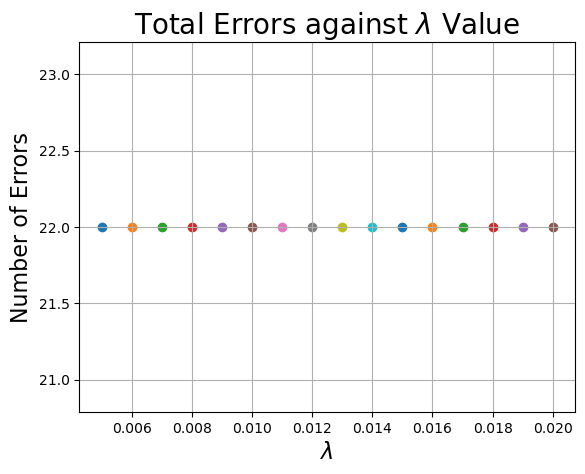

In [19]:
# Create two counters that indicate if we are in class 1 or class 0.
cClass1_val = 34
cClass0_val = cClass1_val + 34

val = 0.001
lambdas = []

for i in range(5, 21):
    lambdas.append((val*i))

# Counters for correct classifications.
class1_counter = 0
class0_counter = 0

# Counters for incorrect classifications. Naming convention: errors_classcorrect.
class1_errors = 0
class0_errors = 0

# Determine with which regularization value fewer errors are obtained.
for l in lambdas:

    # There are 134 features, 1 more for bias, another one for lambda. This is the initial condition.
    w1 = np.zeros((1,136))
    # Equal weights
    weight = 1/134

    # Initialize the parameter vector with the same weights for all features.
    for i in range(len(w1)):
        w1[i] = weight

    # Put the regularization parameter in the last position of the initial parameter condition vector.
    w1[:,np.shape(w1)[1]-1] = l

    # Find the optimal parameter vector with the lambda of the current iteration.
    res1 = minimize(cross_ent, w1.flatten(), method='BFGS')
    w_opt = column(res1.x[:-1])

    # Perform classification using the logistic regression decision rule.
    for i in range(np.shape(mFeat1_aux)[1]):
        # If the data is from class 1
        if i < cClass1_val:
            if w_opt.T @ column(mFeat1_aux[:,i]) < 0:
                class1_counter += 1 
            else:
                class1_errors += 1
        # If the data is from class 0
        elif i >= cClass1_val and i < cClass0_val:
            if w_opt.T @ column(mFeat1_aux[:,i]) > 0:
                class0_counter += 1
            else:
                class0_errors += 1
    
    total_errors = class1_errors + class0_errors
    
    # For each lambda, print the number of errors the classifier made.
    print(f'\nlambda: {l}')
    print(f'class1_errors: {class1_errors}')
    print(f'class0_errors: {class0_errors}\n')

    # Plot the error of the current iteration against its respective lambda value.
    plt.scatter(l, total_errors)
    plt.grid(linestyle='-')
    plt.title('Total Errors against $\lambda$ Value', fontsize=20)
    plt.xlabel('$\lambda$', fontsize=16)
    plt.ylabel('Number of Errors', fontsize=16)

    # Reset the counters to plot with the next lambda.
    class1_errors = 0
    class0_errors = 0
    total_errors = 0
    class1_counter = 0
    class0_counter = 0


### h) Confusion Matrix with Validation Data

With the value of λ selected in part g), we calculate the confusion matrix on the validation data. 

In [20]:
# Chosen lambda
l = 0.019

# Counters for correct classifications
class1_counter = 0
class0_counter = 0

# Naming convention: errors_classcorrect
class1_errors = 0
class0_errors = 0

# This is the initial condition.
w1 = np.zeros((1,136))

# Put the regularization parameter in the last position of the initial parameter condition vector
w1[:,np.shape(w1)[1]-1] = l

# Find the optimal parameter vector
res1 = minimize(cross_ent, w1.flatten(), method='BFGS')
w_opt = column(res1.x[:-1])

# Perform classification
for i in range(np.shape(mFeat1_aux)[1]):
    # If it is from class 1.
    if i < cClass1_val:
        if w_opt.T @ column(mFeat1_aux[:,i]) < 0:
            class1_counter += 1 
        else:
            class1_errors += 1
    # If it is from class 0.
    elif i >= cClass1_val and i < cClass0_val:
        if w_opt.T @ column(mFeat1_aux[:,i]) > 0:
            class0_counter += 1
        else:
            class0_errors += 1

# Calculate total errors in quantity and percentage.
total_errors = class1_errors + class0_errors
error_val = total_errors/np.shape(mFeat1_aux)[1]

# Percentage of error when classifying by class. Naming convention: e_class
e_class1 = class1_errors/np.shape(mClass1_val)[1]
e_class0 = class0_errors/np.shape(mClass0_val)[1]

# Correct classifications
correct = class1_counter + class0_counter
percentage_correct = correct/np.shape(mFeat1_aux)[1]

print(f'Number of correct classifications: {correct}')
print(f'Percentage of correct classifications (validation data): {np.round(percentage_correct, 4)*100}%\n')

print(f'Class 1 classification errors: {class1_errors}')
print(f'Class 0 classification errors: {class0_errors}')
print(f'Total number of errors: {total_errors}')
print(f'Error percentage (validation data): {np.round(error_val, 4)*100}% \n')

# Create the confusion matrix and print it as a dataframe.
confusion = np.array([[class1_counter, class1_errors], [class0_errors, class0_counter]])
df = pd.DataFrame(confusion, columns=['Class 1', 'Class 0'], index=['Class 1', 'Class 0'])

print(f'Confusion matrix: \n {df} \n')
print(f'Class 1 Error Percentage: {class1_errors}/{np.shape(mClass1_val)[1]} = {np.round(e_class1, 4)*100}%\n')
print(f'Class 0 Error Percentage: {class0_errors}/{np.shape(mClass0_val)[1]} = {np.round(e_class0, 4)*100}%\n')


Number of correct classifications: 55
Percentage of correct classifications (validation data): 80.88%

Class 1 classification errors: 4
Class 0 classification errors: 9
Total number of errors: 13
Error percentage (validation data): 19.12% 

Confusion matrix: 
          Class 1  Class 0
Class 1       30        4
Class 0        9       25 

Class 1 Error Percentage: 4/34 = 11.76%

Class 0 Error Percentage: 9/34 = 26.47%



### i) Bar Graph

Using a single bar graph, we plot each pair ($j$, $|w_{hj}|$) (i.e., the horizontal axis of the graph is the index of the feature and the vertical axis is the magnitude of the element of the vector), j = 1, . . . , 134. We identify on the graph the components of the face to which each feature belongs. 


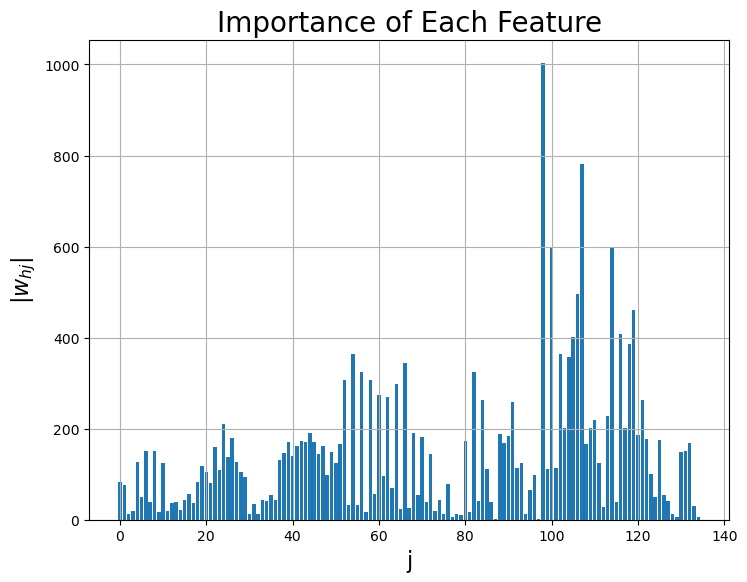


Indices of the right brow: [36 38 40 42 44 46 48 50]

Indices of the left brow: [52 54 56 58 60 62 64 66]

Indices of the right eye: [ 0  2  4  6  8 10 12 14 16]

Indices of the left eye: [18 20 22 24 26 28 30 32 34]

Indices of the nose: [68 70 72 74 76 78 80 82 84 86 88 90 92 94 96]

Indices of the mouth: [ 98 100 102 104 106 108 110 112 114 116 118 120 122 124]

Indices of the face outline: [126 128 130 132]



In [21]:
# Create lists for the data of the horizontal and vertical axes respectively.
js = []
mags = []
for i in range(len(w_opt)):
    js.append(i)
    mags.append(np.abs(float(w_opt[i])))

# Build the graph with the lists created above.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(js, mags)
plt.grid()
plt.title('Importance of Each Feature', fontsize=20)
plt.xlabel('j', fontsize=16)
plt.ylabel('$|w_{hj}|$', fontsize=16)
plt.show()


# Print the indices where each feature is located to compare with the results obtained in the bar graph. 
print(f'\nIndices of the right brow: {right_brow}\n')
print(f'Indices of the left brow: {left_brow}\n')
print(f'Indices of the right eye: {right_eye}\n')
print(f'Indices of the left eye: {left_eye}\n')
print(f'Indices of the nose: {nose}\n')
print(f'Indices of the mouth: {mouth}\n')
print(f'Indices of the face outline: {face}\n')


It is clear that the indices of greatest importance for deciding whether the facial expression is class 1 or class 0 are the indices related to the mouth, as the graph shows a much higher magnitude of the parameters of the classification hyperplane around these indices compared to the rest. The next most important indices correspond to those of the left eyebrow and the nose. The least important indices correspond to those of the eyes.
